Z = 29721.478139370956
y = 19.0
optimal number of watts to install is: 5985.0 W
Total Captial Cost: $19258.0


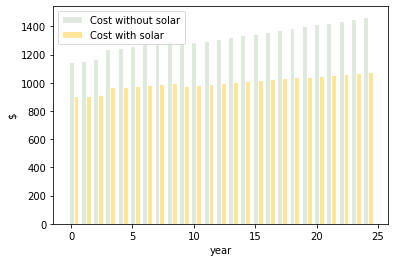

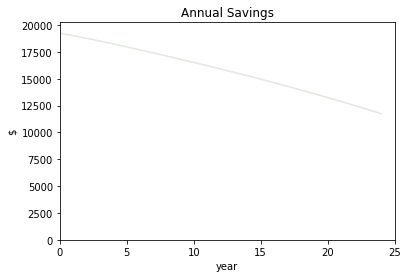

In [16]:
# installing and importing mip
#!pip install --user mip
from mip import *
import math
import matplotlib.pyplot as plt
import numpy as np

# defining parameters
E0 = 9000000  # yearly electricity usage (W) from user
E = [E0]  # yearly electricity usage (W) with trend
Cg = [0.00012757,0.00012986626,0.0001324635852,0.0001417490483,0.0001445840293,0.0001474757099,0.0001504252241,0.0001534337285, 0.0001565024031,0.0001554473307,0.0001585562773,0.0001617274029,0.0001649619509,0.00016826119, 0.0001716264138,0.000175058942,0.0001785601209,0.0001821313233,0.0001857739498,0.0001894894288,0.0001932792173,0.0001971448017,0.0002010876977,0.0002051094517,0.0002092116407,0.0002133958735,0.000217663791] # cost of electricity from the grid ($/W)
m = [10]  # yearly maintenance cost ($/panel)
B = 20000  # budget from user
Cp = 315*2.80  # cost of each solar panel ($/panel) (12 modules of 60cell)
Ap = 18.9  # area of solar panel (ft^2) (40 * 68 inches)
Ar = 2000  # area of the roof (ft^2) from user
Armax = (Ar / 2) * 0.8
P = 315  # capacity of each solar panel (W) per hour
F = 2500  # fixed costs of installing solar panels
d = []  # deterioration factor at year i (%)
U = 0.98  # how much energy can be used (%) (factors: irradiation, shadow, direction)
T = 25  # lifespan of solar panels

# filling in depreciation values (currently set to 0.07%)
for t in range(T):
    d.append(0.0007 * t)

# function to fill in Et - linearly decreases by 1.03%
for t in range(1, T):
    E.append(E[t - 1] - (E[t - 1] * 0.0103))

# calculating U
# define variables
soiling = 0.02  # loses due to dirt/dust on panels (higher for high pollution, low rainfall areas)
shading = 0.03  # might change to be an input from users
snow = 0  # assume that homeowner will clear snow from panels
mismatch = 0.02  # electrical losses due to manufacturing
wiring = 0.02  # loss between DC and AC conversion
connections = 0.005  # loss between electrical connectors
nameplaterating = 0.01
availability = 0.03

U = (1 - soiling) * (1 - shading) * (1 - snow) * (1 - mismatch) * (1 - wiring) * (1 - connections) * (
        1 - nameplaterating) * (1 - availability)

# convert m into present value - TODO
i = 0.00206
for t in range(1,T):
    m.append(10/((1+i) ** t))

# using E @ t=0
Pn = math.ceil((E0 / 365) / (P * U))  # number of solar panels needed to fulfill at least 100% of electricity from the grid

# initializing model
model = Model()

# initializing decision variable
y = model.add_var(name='y', var_type=INTEGER)  # number of solar panels

# initializing the objective function
model.objective = minimize(xsum((E[t] - ((y * P * U * 365) * (1 - d[t]))) * Cg[t] + (m[t] * y) for t in range(T)))

# adding constraints
model += (y * Cp) + F <= B  # budget constraint
model += y * Ap <= Armax  # area of roof constraint **NEED TO ADD FACTOR TO CALCULATE USABLE ROOF SIZE**
model += Pn - y >= 0  # fulfill demand constraint
model += y >= 0  # non-negativity constraint

# solving the MIP
status = model.optimize()

# printing solution
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    print("Z = {}".format(model.objective_value))
    print("y = {}".format(y.x))  # printing decision variable value
    numWatts = y.x * P
    numPanels = y.x
    print("optimal number of watts to install is: " + str(numWatts) + " W")
    if numPanels > 0:
        totalCost = (numPanels * Cp) + F
    else:
        totalCost = 0
    print("Total Captial Cost: $" + str(totalCost))
if status == OptimizationStatus.NO_SOLUTION_FOUND:
    print("no feasible solution :(")

# yearly grid energy cost w/o solar vs. yearly grid energy cost w/ solar (grouped bar chart)
# set width of bar
barWidth = 0.40

# set height of each bar
costsWithoutSolar = []
for t in range(T):
    costsWithoutSolar.append(E[t] * Cg[t])
#print(costsWithoutSolar)

costsWithSolar = []
for t in range(T):
    costsWithSolar.append(max(0, (E[t] - ((numPanels * P * U * 365) * (1 - d[t]))) * Cg[t]))  # will need to change to Cgt
#print(costsWithSolar)

# set position of bar on X axis
r1 = np.arange(len(costsWithoutSolar))
r2 = [x + barWidth for x in r1]

#make the plot
plt.bar(r1, costsWithoutSolar, color='#e0e9ddff', width=barWidth, edgecolor='white', label='Cost without solar')
plt.bar(r2, costsWithSolar, color='#ffe599ff', width=barWidth, edgecolor='white', label='Cost with solar')

plt.xlabel('year')
plt.ylabel('$')
plt.legend()
plt.show()


# payback period (line graph)
year = []
for t in range(T):
    year.append(t)

savings = []
for t in range(T):
    savings.append(costsWithoutSolar[t] - costsWithSolar[t])
#print(savings)

yoySavings = [totalCost]
for t in range(1, T):
    yoySavings.append(max(0,yoySavings[t-1] - savings[t-1]))
#print(yoySavings)

plt.xlim(0, 25)
plt.ylim(0, totalCost + 1000)
plt.xlabel('year')
plt.ylabel('$')
plt.title('Annual Savings')
plt.plot(year, yoySavings, color='#e0e9ddff')
plt.show()